# Uncertainty module

To demonstrate the uncertainty module, we consider the toy prediction model
$$ f_{\alpha, \beta}(t) = \cos(t * \alpha + \arctan(\beta) )$$
for which $\alpha$ and $\beta$ are to be fitted.

The statistical model considered is $$ y = \cos(t * \alpha + \arctan(\beta)) + \sigma \varepsilon$$ while the data is really generated as $$y = \cos(t^* * \alpha + \arctan(\beta)) + \sigma \varepsilon$$ with $t = t^* + \sigma_2 \varepsilon_t$, and $\varepsilon$ following uniform noise.

In [40]:

import aduq.uncertainty as uq
import numpy as np

np.random.seed(1)

noise_lev_out = 0.25
noise_lev_in = 0.2

n_obs = 40
n_par = 2
ts = np.linspace(0, 10, n_obs)

p_star = np.array([1.3, 2.4])
ys = np.cos(ts * p_star[0] + np.arctan(p_star[1])) + np.random.uniform( - noise_lev_out, noise_lev_out, n_obs)

ts = ts + np.random.normal(0, noise_lev_in, n_obs)

ts_perturb = ts 
def pred(x):
    return np.cos(ts * x[0] + np.arctan(x[1]))

def pred_grad(x):
    der_cos = -np.sin(ts * x[0] + np.arctan(x[1]))
    return np.array([ts * der_cos,  (1/ (1 + x[1]**2)) * der_cos])
    
def score(x):
    return np.sum((pred(x) - ys) **2)


import numpy as np
import matplotlib.pyplot as plt

# For plotting purposes
from math import pi
angles = np.linspace(0, 2 * pi, 1000)
circle = np.array([np.cos(angles), np.sin(angles)])

def half_cov(cov):
    vals, vects = np.linalg.eigh(cov)
    return (np.sqrt(vals) * vects) @ vects.T

def repr_gauss(mean, cov, rad =1.0):
    loc_circle = circle.copy()
    return mean + rad * (half_cov(cov) @ loc_circle).T


The uncertainty quantification methods in uncertainty module are ad hoc methods, for which previous calibration is required.

In [41]:
from aduq.optim import optim_CMA


result = optim_CMA(
    np.zeros(n_par), score=score,
    chain_length=400,
    radius_factor= .4, cov_updt_speed=.2, radius_ini=2.0, per_step=1000, silent=False)

opti_param = result.opti_param

# Deal with symmetry issue
if opti_param[0] < 0:
    opti_param = -opti_param

Score at step 0: 62.090955471156825
Updating covariance radius
Updating covariance radius
Updating covariance radius
Score at step 5: 1.1801946073747756
Updating covariance radius
Updating covariance radius
Updating covariance radius
Updating covariance radius
Updating covariance radius
Score at step 10: 1.1800797880624359
Updating covariance radius
Updating covariance radius
Updating covariance radius
Updating covariance radius
Updating covariance radius
Score at step 15: 1.1800797709556192
Updating covariance radius
Updating covariance radius
Updating covariance radius
Updating covariance radius
Updating covariance radius
Score at step 20: 1.1800797709529296
Updating covariance radius
Updating covariance radius
Converged after 23 iterations (updt on x < 1e-08)


In [42]:
fim_mat, cov = uq.fim(pred_grad(opti_param), res = ys - pred(opti_param), weights = 1.0)

uq.fim_pval(p_star, opti_param, cov, fim_mat)

0.041078844646881496

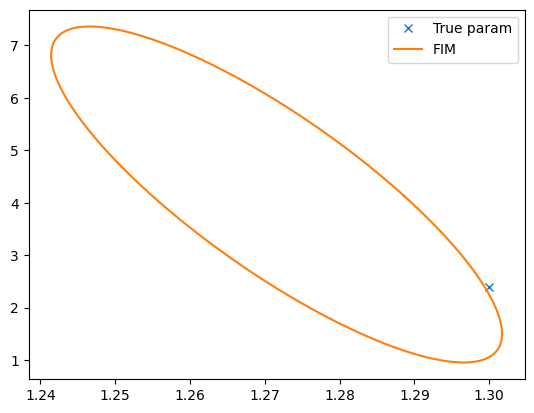

In [43]:
from scipy.stats import chi2

hist_param = np.array(result.hist_param)

plt.plot(p_star[0], p_star[1], "x", label="True param")
fim_circ = repr_gauss(opti_param, cov, chi2(2).ppf(0.95) ** .5) # Confidence region computed using FIM
plt.plot(fim_circ[:, 0], fim_circ[:, 1], label="FIM")
plt.legend()
plt.show()

In [44]:
beale_results = uq.beale_boundary(opti_param, score, cov, n_obs=n_obs, conf_lev=.95, n_boundary = 2000)

/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/uncertainty/beale.py:248: UserWarning: 99/2000 line searches procedure failed.
  warnings.warn(f"{n_failed}/{n_boundary} line searches procedure failed.")


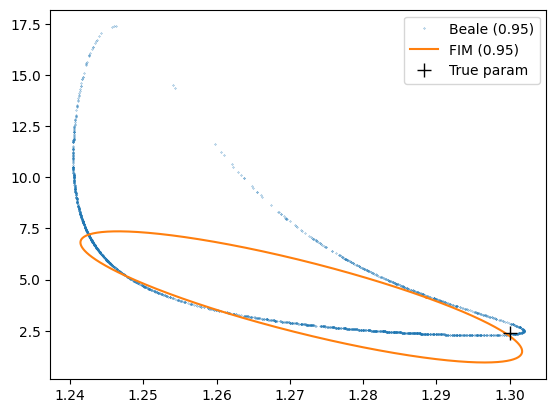

In [45]:
bound = np.array(beale_results["boundary"])

plt.plot(bound[:, 0], bound[:, 1], '.', markersize=.5, label="Beale (0.95)")
plt.plot(fim_circ[:, 0], fim_circ[:, 1], label="FIM (0.95)")
# plt.plot(opti_param[0], opti_param[1], "+")
plt.plot(p_star[0], p_star[1], "+", markersize=10.0, color="black", label="True param")
plt.legend()
plt.show()

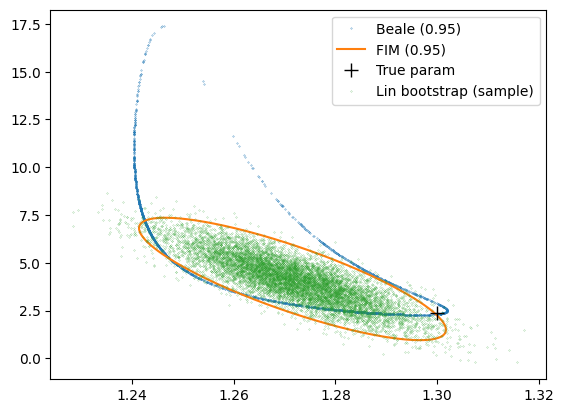

In [46]:
deltas_boot = np.array(uq.lin_bootstrap(res = ys - pred(opti_param), grad= pred_grad(opti_param), n_boot=10**4))
sample_boot = deltas_boot + opti_param

bound = np.array(beale_results["boundary"])

plt.plot(bound[:, 0], bound[:, 1], '.', markersize=.5, label="Beale (0.95)")
plt.plot(fim_circ[:, 0], fim_circ[:, 1], label="FIM (0.95)")
# plt.plot(opti_param[0], opti_param[1], "+")
plt.plot(p_star[0], p_star[1], "+", markersize=10.0, color="black", label="True param")
plt.plot(sample_boot[:, 0], sample_boot[:,1], '.', markersize=.3, label="Lin bootstrap (sample)")
plt.legend()
plt.show()


In [47]:
def calib(data):
    def score(par):
        return np.sum((pred(par) - data) **2)
    
    return optim_CMA(opti_param, score, chain_length=3, cov_ini=cov, radius_ini = .1, per_step=1000, silent=True).opti_param

bootstrap_res = np.array(uq.bootstrap(100, calib, ys, pred(opti_param), parallel=False))

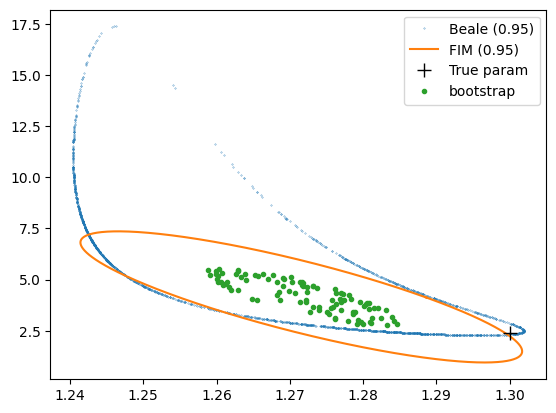

In [9]:
bootstrap_res = np.array(bootstrap_res)

plt.plot(bound[:, 0], bound[:, 1], '.', markersize=.5, label="Beale (0.95)")
plt.plot(fim_circ[:, 0], fim_circ[:, 1], label="FIM (0.95)")
# plt.plot(opti_param[0], opti_param[1], "+")
plt.plot(p_star[0], p_star[1], "+", markersize=10.0, color="black", label="True param")
plt.plot(bootstrap_res[:, 0], bootstrap_res[:, 1], ".", label="bootstrap")
plt.legend()
plt.show()

## Second exemple and plotting submodule

In [10]:
import aduq.uncertainty.plot as uplt
from functools import partial

n_data = 200
n_feat = 2
sigma = .2

x = np.random.normal(0,1, (n_data, n_feat))

def pred(par):
    return np.cos(x @ par) + 0.01 * np.tan(x @ np.sin(par))

par_star = np.random.normal(0,1, n_feat)
pred_star = pred(par_star)

obs = pred_star + sigma * np.random.normal(0,1, n_data)

par_0 = np.zeros(n_feat)
def score(par, obs):
    return np.sqrt(np.mean((obs - pred(par))**2))

cond = False

loc_score = partial(score, obs=obs)

while not cond:
    optim_res = optim_CMA(
        par_0,
        loc_score,
        chain_length=1000, per_step=400,
        cov_updt_speed=.1, radius_factor=.9,
        parallel=False , silent=True, xtol=10** (-12), ftol=10**(-15))

    par_opti = optim_res.opti_param

    cond = (loc_score(par_star) > loc_score(par_opti))

Converged after 153 iterations (updt on f < 1e-15)
Converged after 149 iterations (updt on f < 1e-15)


In [11]:
def pred_der(par):
    der_1 =  (- np.sin(x @ par) * x.T).T
    der_2 =   0.01 * ((1 + np.tan(x @ np.sin(par))**2 ) * x.T).T * np.cos(par)
    return (der_1 + der_2).T


der_opt = pred_der(par_opti)
res = obs - pred(par_opti)

fim, cov_fim = uq.fim(grad = der_opt, res=res)

uq.fim_pval(par_star, par_opti, cov_fim)

0.41301157472680494

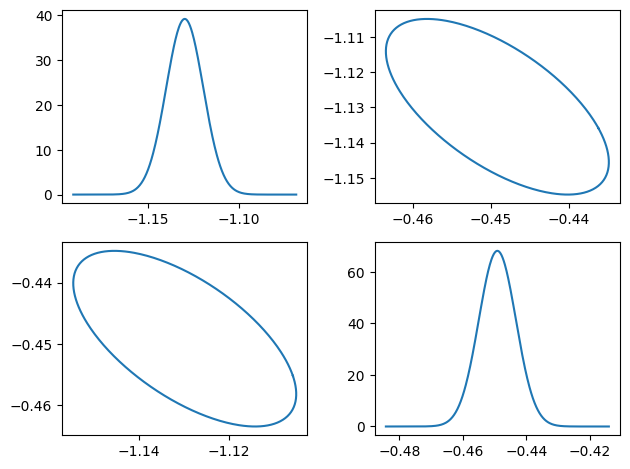

In [12]:
fig, ax = uplt.start_plot(n_feat)
uplt.grid_plot_2D_gauss(fig, ax, par_opti, cov_fim, conf_lev=.95)
fig.tight_layout()

### 2. Beale

In [13]:
# To use Beale's UQ, the score must a MSE type. Here we convert the RMSE to MSE.

from aduq.misc import post_modif

score_2 = post_modif(lambda x: x**2)(loc_score)
boundary = uq.beale_boundary(par_opti, score_2, cov_fim, n_obs=n_data, conf_lev=.95, n_boundary=4000)

/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/uncertainty/beale.py:248: UserWarning: 104/4000 line searches procedure failed.
  warnings.warn(f"{n_failed}/{n_boundary} line searches procedure failed.")


In [14]:
uq.beale_pval(n_param=n_feat, n_obs=n_data, score_param = score_2(par_star), score_opt = score_2(par_opti))

0.2550248296920832

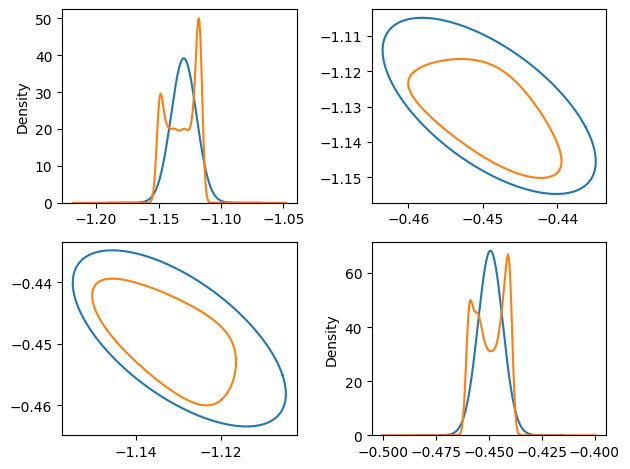

In [15]:
fig, ax = uplt.grid_plot_2D_sample_contour(fig, ax, np.array(boundary["boundary"]))
fig.tight_layout()

fig

In [16]:
def calibration(obs, **kwargs):
    return optim_CMA( param_ini=par_opti, score = partial(score, obs=obs), parallel=True, **kwargs).opti_param

boot_sample = uq.bootstrap(n_boot=64, calib = calibration, obs=obs, opti_pred = pred(par_opti), parallel=False, xtol=1e-5, ftol=1e-6, chain_length=100, radius_ini=0.02, silent=True)


Converged after 32 iterations (updt on f < 1e-06)
Converged after 32 iterations (updt on f < 1e-06)
Converged after 35 iterations (updt on f < 1e-06)
Converged after 33 iterations (updt on f < 1e-06)
Converged after 32 iterations (updt on f < 1e-06)
Converged after 32 iterations (updt on f < 1e-06)
Converged after 38 iterations (updt on f < 1e-06)
Converged after 33 iterations (updt on f < 1e-06)
Converged after 32 iterations (updt on f < 1e-06)
Converged after 33 iterations (updt on f < 1e-06)
Converged after 32 iterations (updt on f < 1e-06)
Converged after 33 iterations (updt on f < 1e-06)
Converged after 32 iterations (updt on f < 1e-06)
Converged after 33 iterations (updt on f < 1e-06)
Converged after 33 iterations (updt on f < 1e-06)
Converged after 38 iterations (updt on f < 1e-06)
Converged after 33 iterations (updt on f < 1e-06)
Converged after 33 iterations (updt on f < 1e-06)
Converged after 34 iterations (updt on f < 1e-06)
Converged after 32 iterations (updt on f < 1e-06)


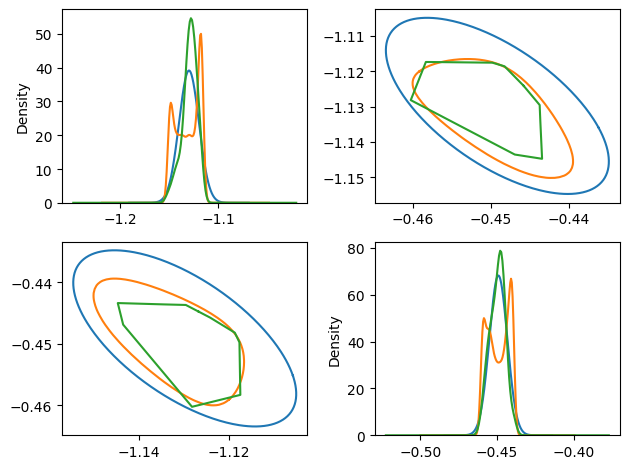

In [17]:
fig, ax = uplt.grid_plot_2D_sample_contour(fig, ax, np.array(boot_sample))
fig.tight_layout()

fig